# Performance evaluation of the gradient descent algorithm

In [1]:
%load_ext autoreload
%autoreload 2
from pytree import *
import random
import matplotlib.pyplot as plt
import numpy
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

print(__version__)
print(__git_version__)

0.0.6
6a7dd839335e0fdbfd073b0525a744e637c9a193


In [2]:
min_x = 1
max_x = 1e9
nb_breakpoints = 6
size = 200
numpy.random.seed(27)
#breakpoints = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), nb_breakpoints))))
breakpoints = [10**n for n in range(1, 9)]
print(f'Breakpoints: {breakpoints}')
x_list = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), size))))
interval_idx = 0
y_list = []
tmp_break = breakpoints + [numpy.inf]
for i, x in enumerate(x_list):
    if x > tmp_break[interval_idx]:
        interval_idx += 1
    assert x <= tmp_break[interval_idx]
    slope = interval_idx*1e-10
    intercept = (interval_idx+1)*10*1e-10
    y_list.append(x*slope + intercept)
dataset = list(zip(x_list, y_list))

Breakpoints: [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]


In [3]:
sigma = 0.1
noisy_dataset = [(x, y+numpy.random.normal(scale=sigma)*x*1e-10) for x, y in dataset]
x = [t[0] for t in noisy_dataset] 
x = numpy.array(x)
y = [t[1] for t in noisy_dataset] 
y = numpy.array(y)

In [4]:
%%time
leaf = Leaf(x, y, Config(mode='log', epsilon=1e-12))

CPU times: user 3.1 ms, sys: 0 ns, total: 3.1 ms
Wall time: 3.13 ms


In [5]:
%%time
df = leaf._compute_log_parameters(start_coeff=max(0, leaf._compute_classical_coeff()),
                                  start_intercept=max(0, leaf._compute_classical_intercept()),
                                  eps=1e-15, step_fact=0.1,
                                  max_iter=1000, return_search=True,
)
df

CPU times: user 702 ms, sys: 5.09 ms, total: 707 ms
Wall time: 707 ms


,coefficient,intercept,error,index
0,7.986585e-10,0.000000e+00,162.200505,0
1,4.616018e-10,-1.525238e-11,74.624909,1
2,4.508851e-10,-1.592460e-11,73.569486,2
3,4.420074e-10,-1.652358e-11,72.849590,3
4,4.347602e-10,-1.705713e-11,72.372295,4
...,...,...,...,...
410,4.099791e-10,-6.077879e-11,71.513528,410
411,4.099791e-10,-6.077879e-11,71.513528,411
412,4.099791e-10,-6.077882e-11,71.513528,412
413,4.099791e-10,-6.077882e-11,71.513528,413


In [6]:
df['prev_coeff'] = df['coefficient'].shift(1)
df['prev_inter'] = df['intercept'].shift(1)
df

,coefficient,intercept,error,index,prev_coeff,prev_inter
0,7.986585e-10,0.000000e+00,162.200505,0,NaN,NaN
1,4.616018e-10,-1.525238e-11,74.624909,1,7.986585e-10,0.000000e+00
2,4.508851e-10,-1.592460e-11,73.569486,2,4.616018e-10,-1.525238e-11
3,4.420074e-10,-1.652358e-11,72.849590,3,4.508851e-10,-1.592460e-11
4,4.347602e-10,-1.705713e-11,72.372295,4,4.420074e-10,-1.652358e-11
...,...,...,...,...,...,...
410,4.099791e-10,-6.077879e-11,71.513528,410,4.099791e-10,-6.077876e-11
411,4.099791e-10,-6.077879e-11,71.513528,411,4.099791e-10,-6.077879e-11
412,4.099791e-10,-6.077882e-11,71.513528,412,4.099791e-10,-6.077879e-11
413,4.099791e-10,-6.077882e-11,71.513528,413,4.099791e-10,-6.077882e-11


/home/tom/.cache/pypoetry/virtualenvs/pytree-ulWrBEt--py3.7/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


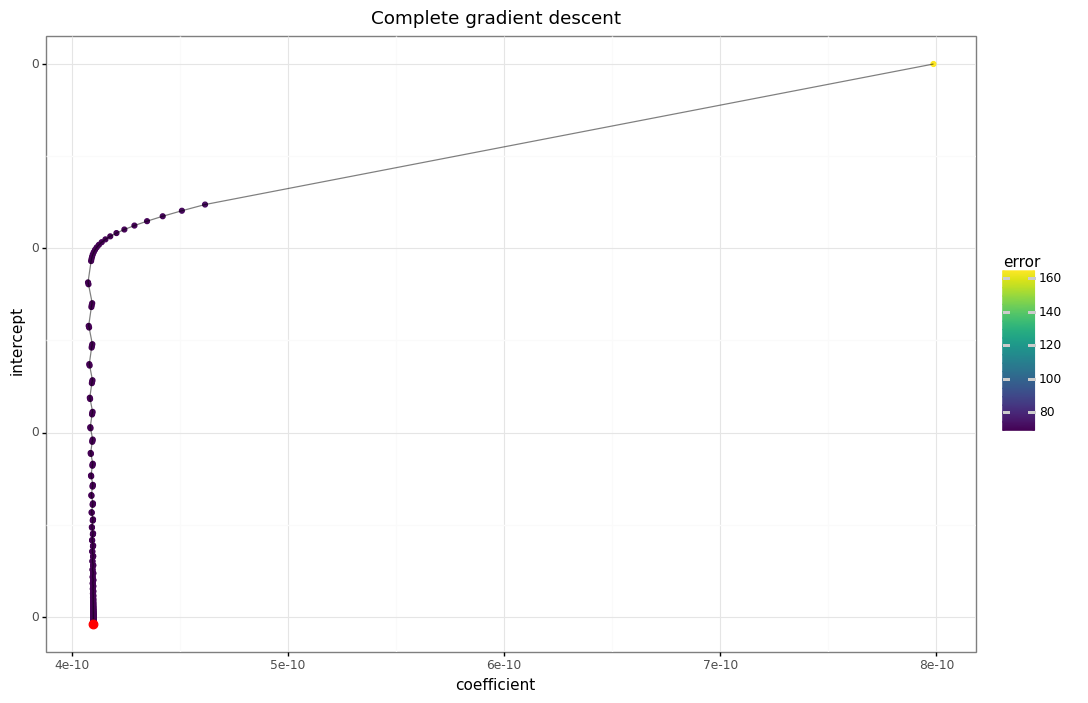

<ggplot: (-9223363249201221190)>

In [7]:
(ggplot(df)
    + aes(x='coefficient', y='intercept')
    + geom_point(aes(color='error'))
    + geom_segment(aes(xend='prev_coeff', yend='prev_inter'), alpha=0.5)
    + geom_point(data=df.tail(n=1), color='red', size=3)
    + theme_bw()
    + ggtitle('Complete gradient descent')
)

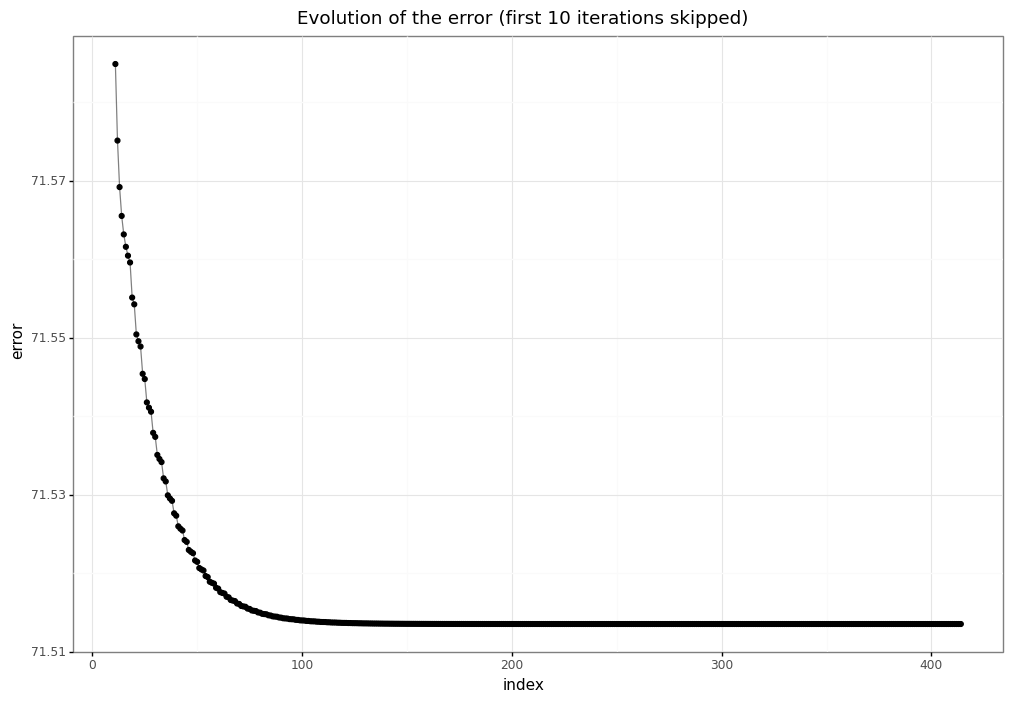

<ggplot: (-9223363249203863436)>

In [8]:
(ggplot(df[df['index'] > 10])
    + aes(x='index', y='error')
    + geom_point()
    + geom_line(alpha=0.5)
    + theme_bw()
    + ggtitle('Evolution of the error (first 10 iterations skipped)')
)

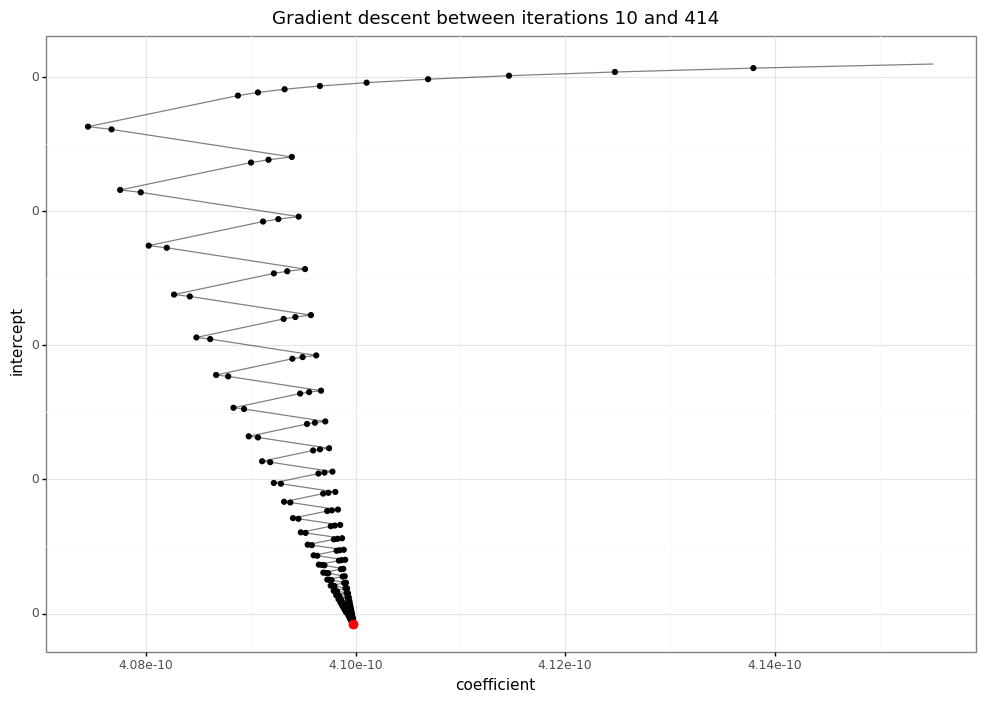

<ggplot: (8787650711181)>

In [9]:
def plot_index(min_index, max_index, global_min=None, global_max=None):
    global_min = global_min or min_index
    global_max = global_max or max_index
    global_df = df[(df['index'] >= global_min) & (df['index'] <= global_max)]
    xlims = global_df['coefficient'].min(), global_df['coefficient'].max()
    ylims = global_df['intercept'].min(), global_df['intercept'].max()
    return (ggplot(df[(df['index'] >= min_index) & (df['index'] <= max_index)])
        + aes(x='coefficient', y='intercept')
        + geom_point()
        + geom_segment(aes(xend='prev_coeff', yend='prev_inter'), alpha=0.5)
        + geom_point(data=df.tail(n=1), color='red', size=3)
        + theme_bw()
        + expand_limits(x=xlims, y=ylims)
        + ggtitle(f'Gradient descent between iterations {min_index} and {max_index}')
    )
plot_index(10, df['index'].max())

In [10]:
from plotnine.animation import PlotnineAnimation
from IPython.display import Video

plots = (plot_index(10, n, 10, df['index'].max()) for n in range(10, df['index'].max(), 1))
ani = PlotnineAnimation(plots, interval=100, repeat_delay=500)
ani.save('/tmp/animation.mp4')
Video("/tmp/animation.mp4", embed=True)